In [1]:
import pickle
import time

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table

import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm

In [2]:
def count_all(data, thr):
    tp = ((data['preds'] >= thr) * (data['target'] == 1)).sum()
    fp = ((data['preds'] >= thr) * (data['target'] == 0)).sum()
    tn = ((data['preds'] < thr) * (data['target'] == 0)).sum()
    fn = ((data['preds'] < thr) * (data['target'] == 1)).sum()
    
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return prec, recall, fpr

def plot_all(data, quants, thrs, data_name, cumul=False, plot_obj_num=True):
    precs = []
    recalls = []
    fpr_1 = []
    sample_num = []
    for i in range(len(quants)-1):
        if cumul:
            t = data[data['Z'] >= quants[i]]
        else:
            t = data[(data['Z'] >= quants[i]) & (data['Z'] <= quants[i+1])]
        prec, recall, fpr = count_all(t, thrs[i])
        precs.append(prec)
        recalls.append(recall)
        fpr_1.append(1-fpr)
        sample_num.append((t[t['target'] == 0].shape[0], t[t['target'] == 1].shape[0]))
        
    font = {'size': 20}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(16, 8))
    plt.xlim(quants[0]-0.01, quants[-1]+0.01)
    plt.ylim(0, 1.02)
    plt.xticks(np.arange(int(quants[0]), 7.5, 0.5), rotation=45)
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    plt.grid()
    
    plt.plot((quants[1:] + quants[:-1]) / 2, precs, label=f'prec', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, recalls, label=f'recall', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, fpr_1, label=f'1-fpr', marker='o')
    plt.plot((quants[1:] + quants[:-1]) / 2, thrs, label=f'thresholds', marker='o')
    plt.vlines(quants, ymin=-0.5, ymax=1.5, colors='black')
    if plot_obj_num:
        for i, x in enumerate(((quants[1:] + quants[:-1]) / 2) - 0.05):
            plt.text(x, 0.52, f'{sample_num[i][0]}', size=7, c='b')
            plt.text(x, 0.48, f'{sample_num[i][1]}', size=7, c='r')
    plt.legend()
    plt.xlabel('Redshift')
    plt.ylabel('prec|recall|1-fpr')
    plt.title(f'{data_name}');
    
    return precs, recalls, fpr_1

In [3]:
data_dir = 'data'

np.random.seed(0)

In [4]:
with open(f'{data_dir}/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    photo_features_list = pickle.load(f)

In [5]:
full = pd.read_csv(f'{data_dir}/full_dr16q_train20_superset.csv')
# full = full.merge(ge[['OBJID', 'Gtest_zooTrue']], on=['OBJID'], how='left')
full.replace(np.nan, None, inplace=True)

/tmp/ipykernel_2047665/2911819179.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  full = pd.read_csv(f'{data_dir}/full_dr16q_train20_superset.csv')


In [6]:
full = full[full['Z'] > -1]
# full = full[full['Z_SYS'] > -1]
full = full[~full['max35_z'].isna()]
full['z_diff'] = full['max35_z'] - full['Z']
full['z_diff_abs'] = np.abs(full['z_diff'])
full['target'] = [None] * full.shape[0]
full.loc[full['superset'], 'target'] = 1
full.loc[full['train20'] & ~full['dr16q_prop'], 'target'] = 0
full['preds'] = [None] * full.shape[0]
full.reset_index(drop=True, inplace=True)
full

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915,-0.006618,0.006618,None,None
1,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841,-0.087857,0.087857,None,None
2,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937,0.038773,0.038773,None,None
3,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.164616,0.17621,0.335601,0.490732,0.161861,2.20362,-0.187918,0.187918,0,None
4,b'4216-55477-0310',0.001978,-0.451088,0.250000,0.250093,0.000271,0.000093,0.000093,True,False,...,0.04414,0.731333,0.042585,0.641517,0.048586,0.309761,0.1008,0.1008,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201514,None,201.934129,12.271040,7.021599,None,None,None,None,False,False,...,0.579473,0.365884,0.170109,0.390067,0.671535,2.78982,-4.12074,4.12074,1,None
1201515,None,36.002095,-0.394057,7.027864,None,None,None,None,False,False,...,0.206266,0.186966,0.111225,0.43636,0.374554,1.815811,-5.004221,5.004221,1,None
1201516,None,179.515381,45.946690,7.029899,None,None,None,None,False,False,...,0.121065,0.378635,0.033186,0.656538,0.075233,0.725941,-6.294876,6.294876,1,None
1201517,None,0.306355,6.436817,7.030458,None,None,None,None,False,False,...,0.639419,0.813738,0.157822,0.607947,0.366948,0.528063,-6.657146,6.657146,1,None


In [7]:
train_20 = full[full['train20'] & ~full['dr16q_prop']].copy()
train_20.reset_index(drop=True, inplace=True)
train_20

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.164616,0.17621,0.335601,0.490732,0.161861,2.20362,-0.187918,0.187918,0,None
1,b'8740-57367-0694',0.002375,5.941903,2.102771,2.09378,0.003675,-0.008992,0.008992,True,False,...,0.222473,0.503271,0.064117,0.24347,0.788925,0.760818,-1.301771,1.301771,0,None
2,b'6177-56268-0595',0.002756,14.974675,2.497000,2.502681,0.002898,0.005681,0.005681,True,False,...,0.743286,1.075822,0.181831,0.12322,0.139387,2.482719,-0.093,0.093,0,None
3,b'4415-55831-0464',0.004052,4.829781,1.619000,1.623999,0.002157,0.004999,0.004999,True,False,...,3.005284,0.117433,0.172892,0.332158,0.139076,1.489399,-0.165417,0.165417,0,None
4,b'7666-57339-0121',0.005026,24.065163,1.615983,1.617055,0.000892,0.001073,0.001073,True,False,...,0.96814,0.203168,0.159178,0.321547,0.3504,1.732276,-1.049335,1.049335,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575553,None,359.989649,17.861844,1.146000,None,None,None,None,False,False,...,0.889243,0.126902,0.234768,0.779276,0.12962,1.257039,0.053739,0.053739,0,None
575554,None,359.989956,5.066145,0.334862,None,None,None,None,False,False,...,2.211479,0.843704,0.429626,3.129062,0.813887,1.891448,-0.169727,0.169727,0,None
575555,None,359.992068,18.476645,1.283000,None,None,None,None,False,False,...,2.330624,0.093557,0.172659,1.232371,0.090907,1.251834,-0.061348,0.061348,0,None
575556,None,359.994125,3.739318,0.483395,None,None,None,None,False,False,...,0.02853,0.377948,0.02758,0.229883,0.031772,0.493921,0.023605,0.023605,0,None


In [8]:
train_20_01, train_20_02 = train_20.iloc[range(0, train_20.shape[0], 2)], train_20.iloc[range(0, train_20.shape[0], 2)]

In [9]:
superset = full[full['superset']].copy()
superset.reset_index(drop=True, inplace=True)
superset

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,None,119.299997,22.527369,-0.011447,None,None,None,None,False,False,...,0.15597,0.276417,0.291609,0.169702,0.417372,3.165899,3.370447,3.370447,1,None
1,None,262.134784,36.734522,-0.011332,None,None,None,None,False,False,...,0.536854,0.495625,0.235876,0.260779,0.873871,3.853072,3.175332,3.175332,1,None
2,None,327.439561,-0.195568,-0.011123,None,None,None,None,False,False,...,0.379007,1.134066,0.167027,0.327934,1.58463,0.360759,3.150843,3.150843,1,None
3,None,217.129032,15.540025,-0.010959,None,None,None,None,False,False,...,0.918186,0.68164,0.261894,0.414532,1.484779,3.052652,3.422959,3.422959,1,None
4,None,183.414213,0.751143,-0.010932,None,None,None,None,False,False,...,0.898445,0.615723,0.254838,0.32151,1.686857,3.344148,3.145932,3.145932,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365340,None,201.934129,12.271040,7.021599,None,None,None,None,False,False,...,0.579473,0.365884,0.170109,0.390067,0.671535,2.78982,-4.12074,4.12074,1,None
365341,None,36.002095,-0.394057,7.027864,None,None,None,None,False,False,...,0.206266,0.186966,0.111225,0.43636,0.374554,1.815811,-5.004221,5.004221,1,None
365342,None,179.515381,45.946690,7.029899,None,None,None,None,False,False,...,0.121065,0.378635,0.033186,0.656538,0.075233,0.725941,-6.294876,6.294876,1,None
365343,None,0.306355,6.436817,7.030458,None,None,None,None,False,False,...,0.639419,0.813738,0.157822,0.607947,0.366948,0.528063,-6.657146,6.657146,1,None


In [10]:
superset_01, superset_02 = superset.iloc[range(0, superset.shape[0], 2)], superset.iloc[range(0, superset.shape[0], 2)]

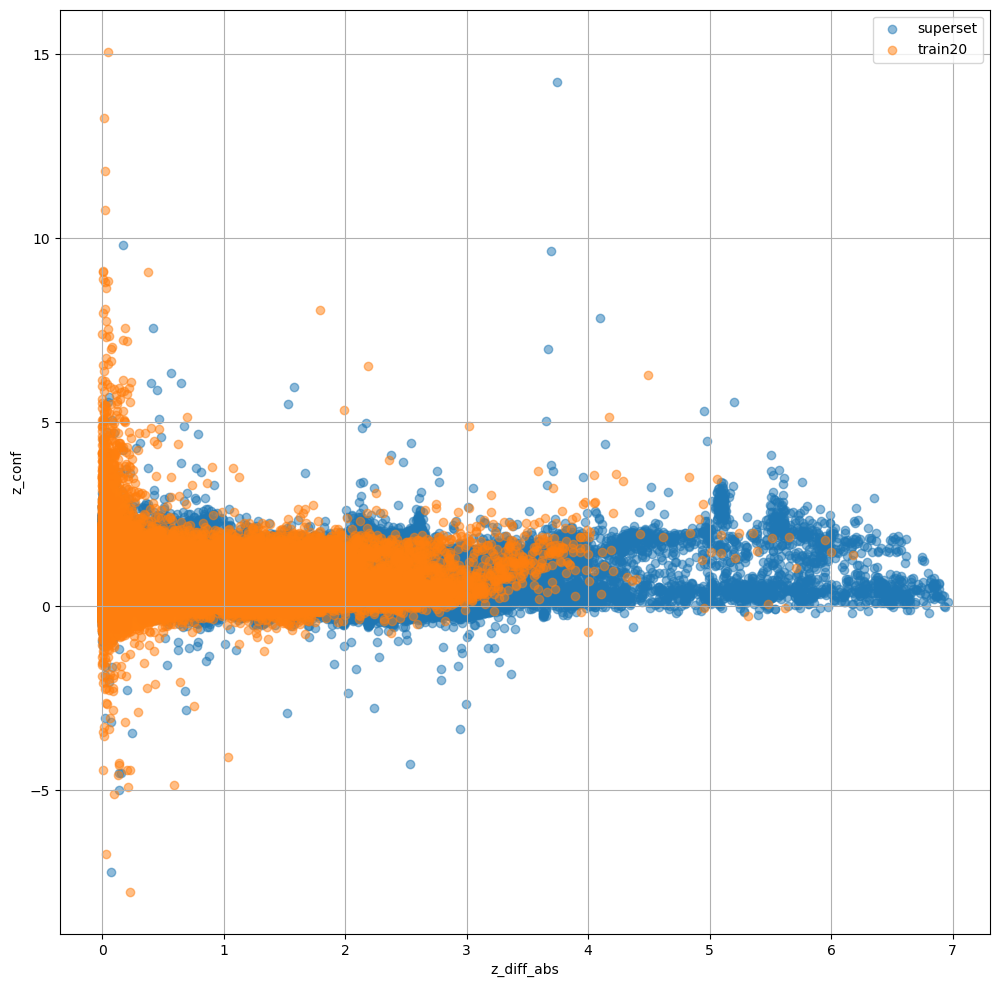

In [11]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 12))
plt.grid()

plt.scatter(superset['z_diff_abs'], superset['decals8tr_g-r'], alpha=0.5, label='superset')
plt.scatter(train_20['z_diff_abs'], train_20['decals8tr_g-r'], alpha=0.5, label='train20')

plt.xlabel('z_diff_abs')
plt.ylabel('z_conf')
plt.legend()
pass;

In [12]:
dr16q = full[(full['dr16q']) & ~(full['train20'])].copy()
dr16q.reset_index(drop=True, inplace=True)
dr16q

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915,-0.006618,0.006618,None,None
1,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841,-0.087857,0.087857,None,None
2,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937,0.038773,0.038773,None,None
3,b'4216-55477-0310',0.001978,-0.451088,0.250000,0.250093,0.000271,0.000093,0.000093,True,False,...,0.04414,0.731333,0.042585,0.641517,0.048586,0.309761,0.1008,0.1008,None,None
4,b'7749-58073-0683',0.002595,31.328982,1.991313,1.987004,0.00234,-0.004309,0.004309,True,False,...,3.100314,0.070568,0.218298,0.707592,0.058718,2.036324,0.057687,0.057687,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260344,b'7167-56604-0276',359.997573,-9.826069,2.439000,2.439799,0.006409,0.000799,0.000799,True,False,...,0.095077,0.06882,0.32337,0.159841,0.092918,2.461787,0.083,0.083,None,None
260345,b'1489-52991-0520',359.997675,0.144870,1.356595,1.358383,0.002561,0.001788,0.001788,True,False,...,0.18965,1.04154,0.11874,0.093032,0.088281,1.286777,-0.18085,0.18085,None,None
260346,b'11546-58488-0078',359.997704,10.564075,1.284287,1.285613,0.000508,0.001326,0.001326,True,False,...,3.509339,0.090166,0.229019,0.555492,0.123056,1.350655,0.16673,0.16673,None,None
260347,b'7848-56959-0054',359.998520,-0.655884,1.355954,1.355999,0.000794,0.000045,0.000045,True,False,...,1.743799,0.086547,0.11947,1.273151,0.084525,1.245215,-0.277751,0.277751,None,None


In [13]:
full_dr16q = full[(full['dr16q'])].copy()
full_dr16q.reset_index(drop=True, inplace=True)
full_dr16q

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,b'7749-58073-0660',0.001415,31.057048,2.035491,2.040685,0.002466,0.005194,0.005194,True,False,...,0.500169,0.814194,0.200983,0.301492,0.319025,2.095915,-0.006618,0.006618,None,None
1,b'7695-57654-0565',0.001526,27.732283,1.770552,1.77408,0.002622,0.003528,0.003528,True,False,...,1.052853,0.098946,0.441917,0.828959,0.089006,1.611841,-0.087857,0.087857,None,None
2,b'11279-58449-0978',0.001535,7.064129,1.574227,1.575559,0.002725,0.001331,0.001331,True,False,...,0.682497,0.523818,0.288939,0.222688,0.217595,1.575937,0.038773,0.038773,None,None
3,b'7596-56945-0162',0.001898,17.773739,2.309000,2.310261,0.003747,0.001261,0.001261,True,False,...,0.164616,0.17621,0.335601,0.490732,0.161861,2.20362,-0.187918,0.187918,0,None
4,b'4216-55477-0310',0.001978,-0.451088,0.250000,0.250093,0.000271,0.000093,0.000093,True,False,...,0.04414,0.731333,0.042585,0.641517,0.048586,0.309761,0.1008,0.1008,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696478,b'6182-56190-0380',359.998922,10.116800,2.415000,2.422902,0.004639,0.007902,0.007902,True,False,...,0.616996,0.585482,0.148855,0.27174,0.70463,2.739029,0.183,0.183,0,None
696479,b'7666-57339-0130',359.999028,24.413548,1.490356,1.488036,0.001223,-0.00232,0.00232,True,False,...,0.354688,0.706257,0.295579,0.172097,0.205009,1.397659,0.028765,0.028765,0,None
696480,b'7134-56566-0408',359.999118,28.954734,2.452000,2.4514,0.00525,-0.0006,0.0006,True,False,...,0.100276,0.072891,0.364991,0.25875,0.084871,2.424912,-0.119,0.119,0,None
696481,b'8741-57390-0060',359.999615,3.268586,1.232962,1.233783,0.000758,0.000821,0.000821,True,False,...,0.141165,1.094194,0.058255,0.069625,0.060528,1.227826,0.086871,0.086871,0,None


In [14]:
prop_dr16q = full[(full['dr16q_prop'])].copy()
prop_dr16q.reset_index(drop=True, inplace=True)
prop_dr16q

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,b'7750-58402-0178',0.023199,33.677090,2.374468,1.695454,0.002444,-0.679013,0.679013,True,True,...,0.57012,0.992144,0.3741,0.069887,0.070744,1.690976,-0.763468,0.763468,None,None
1,b'7751-58081-0010',0.110519,32.520371,6.537026,3.9,-1.0,-2.637026,2.637026,True,True,...,0.252861,0.281398,0.088907,0.440296,0.419978,0.773497,-5.737026,5.737026,None,None
2,b'7666-57339-0127',0.182396,24.708938,2.812042,2.055525,0.002691,-0.756517,0.756517,True,True,...,1.247433,1.46548,0.225657,0.044644,0.052853,2.147255,-0.691276,0.691276,None,None
3,b'7749-58073-0317',0.200670,30.933965,3.346067,0.884013,0.0006,-2.462054,2.462054,True,True,...,0.121087,0.777983,0.083648,0.179611,0.097239,0.828405,-2.575067,2.575067,None,None
4,b'11277-58450-0221',0.447432,8.302736,1.619089,1.096916,0.001626,-0.522173,0.522173,True,True,...,1.424112,0.075639,0.271344,0.861008,0.094598,1.252125,-0.292089,0.292089,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,b'7696-57655-0810',359.586721,30.006652,7.012407,1.040394,0.000788,-5.972012,5.972012,True,True,...,0.311465,0.688074,0.101715,0.223771,0.218125,1.094405,-6.096407,6.096407,None,None
1657,b'7895-57659-0798',359.602008,-3.155726,4.471740,1.416833,0.002218,-3.054907,3.054907,True,True,...,0.211718,1.027776,0.231184,0.03359,0.034834,1.455791,-3.01034,3.01034,None,None
1658,b'7848-56959-0147',359.688329,-0.107161,1.077307,0.638959,0.003373,-0.438348,0.438348,True,True,...,0.64175,0.080963,0.839001,1.353434,0.124084,1.664703,0.641167,0.641167,None,None
1659,b'7895-57659-0851',359.854208,-3.659661,3.333653,0.894096,0.000511,-2.439556,2.439556,True,True,...,0.068439,1.052714,0.037729,0.068901,0.04288,0.891161,-2.404653,2.404653,None,None


In [15]:
prop = []
prop_y = []
r = []
for i in np.arange(0.0, 7.0, 0.5):
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    min_shape = min(t1.shape[0], t2.shape[0])
    prop.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=min_shape, replace=False)])
    prop_y += [0] * min_shape
    prop.append(t2)
    prop_y += [1] * t2.shape[0]
    r.append((min_shape, min_shape == t2.shape[0]))
prop = pd.concat(prop, axis=0)

tree = KDTree(prop[['RA', 'DEC']].values)
d, idx = tree.query(train_20_02[['RA', 'DEC']])
t = train_20_02.drop(train_20_02.index[d.reshape(-1) < 0.0000001])
s = 0
for e in r:
    if e[1]:
        s += e[0]
diff = sum(prop_y) - (len(prop_y) - sum(prop_y))
prop_02 = []
for k, i in enumerate(np.arange(0.0, 7.0, 0.5)):
    if r[k][1]:
        t1 = t[(t['Z'] >= i) & (t['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
        prop_02.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=round(diff * r[k][0] / s), replace=False)])
prop = pd.concat((prop, pd.concat(prop_02)))
prop_y += [0] * (prop.shape[0] - len(prop_y))

prop['target'] = prop_y
prop.sort_values(by=['Z'], inplace=True)
prop.reset_index(drop=True, inplace=True)
prop

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,b'10465-58144-0576',157.601672,31.589120,0.004153,1.63156,0.002181,1.627407,1.627407,True,True,...,4.053457,0.102557,0.182866,0.490752,0.097201,1.730009,1.629947,1.629947,1,None
1,b'11067-58507-0992',21.348922,16.562467,0.006583,1.123435,0.003304,1.116852,1.116852,True,True,...,0.148054,0.864537,0.099055,0.121716,0.112406,1.061954,0.937417,0.937417,1,None
2,b'7415-57097-0842',191.619513,49.916623,0.008189,1.560199,0.002642,1.552009,1.552009,True,True,...,0.46559,0.198179,0.176899,0.345465,0.303223,2.214045,2.051951,2.051951,1,None
3,b'7770-58044-0993',350.520778,30.096626,0.010326,0.990284,0.001618,0.979958,0.979958,True,True,...,0.191977,1.013122,0.094386,0.121584,0.097073,1.06923,1.007555,1.007555,1,None
4,b'8535-58019-0894',256.791721,45.663833,0.015376,1.377521,0.002196,1.362145,1.362145,True,True,...,0.639867,1.378956,0.551146,0.618332,0.894286,2.055761,1.919149,1.919149,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,b'8409-57867-0736',214.826084,58.821845,6.968736,1.19712,0.003626,-5.771616,5.771616,True,True,...,0.192265,0.650236,0.141002,0.539718,1.330687,0.323667,-6.557209,6.557209,1,None
3256,b'9141-57663-0826',321.941715,0.395795,6.970199,1.613146,0.014746,-5.357052,5.357052,True,True,...,0.415133,0.551532,0.165397,0.272957,1.189298,2.944148,-6.341766,6.341766,1,None
3257,b'10754-58224-0524',218.509881,35.990135,6.977830,1.620841,0.003511,-5.356989,5.356989,True,True,...,0.88331,0.337236,1.023886,0.099903,0.171752,1.671431,-5.209862,5.209862,1,None
3258,b'7237-56662-0450',32.666131,-5.778303,6.999089,0.967996,0.001876,-6.031093,6.031093,True,True,...,0.556032,0.91992,0.150907,0.446563,0.149128,0.878162,-6.172089,6.172089,1,None


In [16]:
prop_balance = []
prop_balance_y = []
for i in np.arange(0.0, 7.0, 0.5):
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    min_shape = min(t1.shape[0], t2.shape[0])
    prop_balance.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=min_shape, replace=False)])
    prop_balance_y += [0] * min_shape
    prop_balance.append(t2.iloc[np.random.choice(np.arange(t2.shape[0]), size=min_shape, replace=False)])
    prop_balance_y += [1] * min_shape
prop_balance = pd.concat(prop_balance, axis=0)
prop_balance['target'] = prop_balance_y
prop_balance.sort_values(by=['Z'], inplace=True)
prop_balance.reset_index(drop=True, inplace=True)
prop_balance

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,b'10465-58144-0576',157.601672,31.589120,0.004153,1.63156,0.002181,1.627407,1.627407,True,True,...,4.053457,0.102557,0.182866,0.490752,0.097201,1.730009,1.629947,1.629947,1,None
1,b'11067-58507-0992',21.348922,16.562467,0.006583,1.123435,0.003304,1.116852,1.116852,True,True,...,0.148054,0.864537,0.099055,0.121716,0.112406,1.061954,0.937417,0.937417,1,None
2,b'7415-57097-0842',191.619513,49.916623,0.008189,1.560199,0.002642,1.552009,1.552009,True,True,...,0.46559,0.198179,0.176899,0.345465,0.303223,2.214045,2.051951,2.051951,1,None
3,b'7770-58044-0993',350.520778,30.096626,0.010326,0.990284,0.001618,0.979958,0.979958,True,True,...,0.191977,1.013122,0.094386,0.121584,0.097073,1.06923,1.007555,1.007555,1,None
4,b'8535-58019-0894',256.791721,45.663833,0.015376,1.377521,0.002196,1.362145,1.362145,True,True,...,0.639867,1.378956,0.551146,0.618332,0.894286,2.055761,1.919149,1.919149,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,b'8842-57424-0311',176.589805,39.141618,6.464488,1.119064,0.004094,-5.345423,5.345423,True,True,...,0.766151,0.086551,0.121975,1.281952,0.087906,1.040234,-5.375165,5.375165,1,None
2700,b'8404-57481-0777',219.767067,51.270692,6.520423,0.825711,0.000419,-5.694712,5.694712,True,True,...,1.217216,0.347646,0.106592,0.601127,1.079587,0.999634,-5.871423,5.871423,1,None
2701,None,36.507807,3.049838,6.541200,None,None,None,None,False,False,...,14.610314,6.396335,0.188811,6.544827,0.279561,6.31109,-5.617247,5.617247,0,None
2702,b'11052-58438-0877',26.799025,14.903653,6.558784,1.113971,0.000774,-5.444813,5.444813,True,True,...,0.427648,0.736722,0.128791,0.117611,0.474477,2.082563,-4.559784,4.559784,1,None


In [17]:
prop_dens = []
prop_dens_y = []
for i in np.arange(0.0, 7.0, 0.5):
    t0 = full_dr16q[(full_dr16q['Z'] >= i) & (full_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t1 = train_20_02[(train_20_02['Z'] >= i) & (train_20_02['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    t2 = prop_dr16q[(prop_dr16q['Z'] >= i) & (prop_dr16q['Z'] < i + 0.5)].reset_index(drop=True, inplace=False)
    prop_dens.append(t2)
    prop_dens_y += [1] * t2.shape[0]
    # print(t1.shape)
    prop_dens.append(t1.iloc[np.random.choice(np.arange(t1.shape[0]), size=t0.shape[0]-t2.shape[0], replace=True)])
    prop_dens_y += [0] * (t0.shape[0]-t2.shape[0])
prop_dens = pd.concat(prop_dens, axis=0)
prop_dens['target'] = prop_dens_y
prop_dens.sort_values(by=['Z'], inplace=True)
prop_dens.reset_index(drop=True, inplace=True)
prop_dens

,OBJID,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,dr16q_prop,...,sigma_11_35,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,target,preds
0,None,159.898630,0.058012,0.000146,None,None,None,None,False,False,...,1.205189,0.674219,0.276164,0.342486,1.361248,3.360188,3.235854,3.235854,0,None
1,None,159.898630,0.058012,0.000146,None,None,None,None,False,False,...,1.205189,0.674219,0.276164,0.342486,1.361248,3.360188,3.235854,3.235854,0,None
2,None,133.487654,8.900324,0.000147,None,None,None,None,False,False,...,0.021952,0.725755,0.029313,0.032587,0.023214,0.174836,0.156963,0.156963,0,None
3,None,18.821771,26.332595,0.000339,None,None,None,None,False,False,...,0.906965,1.290531,0.249929,0.686434,0.978242,2.131752,1.992561,1.992561,0,None
4,None,193.271875,46.627116,0.000438,None,None,None,None,False,False,...,0.403708,0.696512,0.195274,0.484459,1.082028,0.843456,0.785796,0.785796,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696445,b'8409-57867-0736',214.826084,58.821845,6.968736,1.19712,0.003626,-5.771616,5.771616,True,True,...,0.192265,0.650236,0.141002,0.539718,1.330687,0.323667,-6.557209,6.557209,1,None
696446,b'9141-57663-0826',321.941715,0.395795,6.970199,1.613146,0.014746,-5.357052,5.357052,True,True,...,0.415133,0.551532,0.165397,0.272957,1.189298,2.944148,-6.341766,6.341766,1,None
696447,b'10754-58224-0524',218.509881,35.990135,6.977830,1.620841,0.003511,-5.356989,5.356989,True,True,...,0.88331,0.337236,1.023886,0.099903,0.171752,1.671431,-5.209862,5.209862,1,None
696448,b'7237-56662-0450',32.666131,-5.778303,6.999089,0.967996,0.001876,-6.031093,6.031093,True,True,...,0.556032,0.91992,0.150907,0.446563,0.149128,0.878162,-6.172089,6.172089,1,None


In [18]:
features_list = ['z_diff_abs', 'conf35_z'] + photo_features_list

In [19]:
X_01 = np.concatenate([train_20_01[features_list].values, superset_01[features_list].values], axis=0)
y_01 = np.concatenate([train_20_01['target'].values, superset_01['target'].values], axis=0).astype(int)
X_02 = np.concatenate([train_20_02[features_list].values, superset_02[features_list].values], axis=0)
y_02 = np.concatenate([train_20_02['target'].values, superset_02['target'].values], axis=0).astype(int)

test = pd.concat((train_20_02, superset_02))

In [20]:
y_01.sum(), y_01.shape

(182673, (470452,))

In [57]:
import warnings
warnings.filterwarnings('ignore')

start = time.time()

boost = lgbm.LGBMClassifier(
    n_estimators=1000, max_depth=6,
    n_jobs=8
)
boost.fit(
    X_01, y_01, 
    eval_set=[
        (X_02, y_02) 
    ], 
    verbose=50
)

print('boost train time: ', time.time() - start)

[50]	valid_0's binary_logloss: 0.1406
[100]	valid_0's binary_logloss: 0.125315
[150]	valid_0's binary_logloss: 0.118523
[200]	valid_0's binary_logloss: 0.113682
[250]	valid_0's binary_logloss: 0.109852
[300]	valid_0's binary_logloss: 0.106549
[350]	valid_0's binary_logloss: 0.103702
[400]	valid_0's binary_logloss: 0.101135
[450]	valid_0's binary_logloss: 0.0987711
[500]	valid_0's binary_logloss: 0.0967466
[550]	valid_0's binary_logloss: 0.0943312
[600]	valid_0's binary_logloss: 0.0922197
[650]	valid_0's binary_logloss: 0.090194
[700]	valid_0's binary_logloss: 0.0881064
[750]	valid_0's binary_logloss: 0.0861913
[800]	valid_0's binary_logloss: 0.0844612
[850]	valid_0's binary_logloss: 0.0826652
[900]	valid_0's binary_logloss: 0.0809144
[950]	valid_0's binary_logloss: 0.079281
[1000]	valid_0's binary_logloss: 0.0776642
boost train time:  39.12340974807739


In [58]:
#decals8tr_g-r

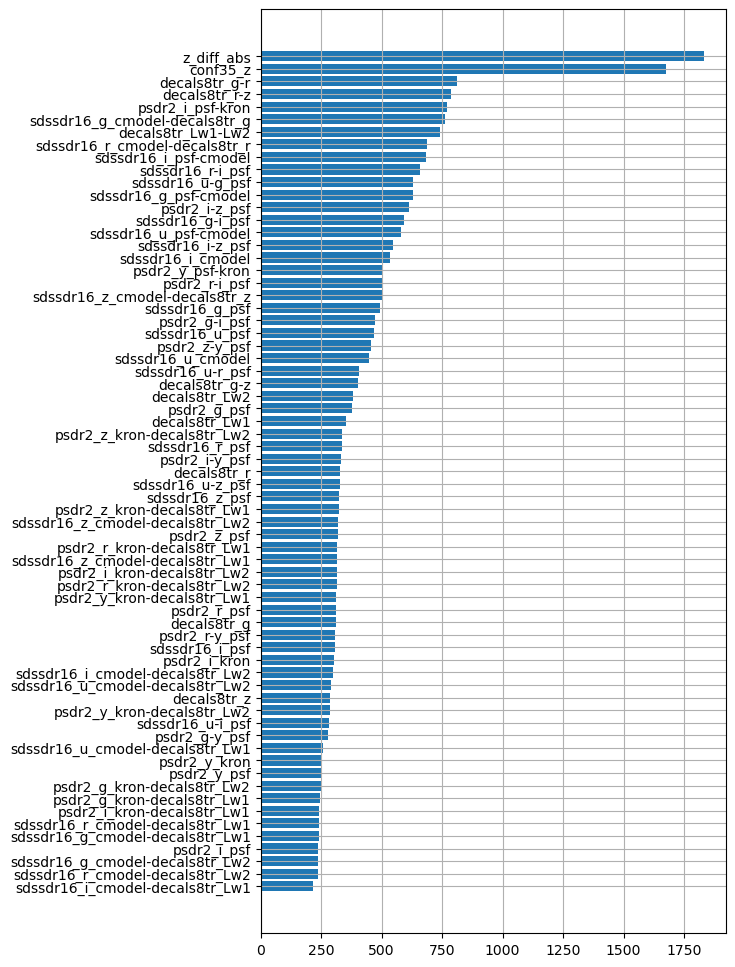

In [59]:
font = {'size': 10}
plt.rc('font', **font)
fig = plt.figure(figsize=(6, 12))
plt.grid()

plt.barh(np.array(features_list)[boost.feature_importances_.argsort()[::]], sorted(boost.feature_importances_)[::]);

In [60]:
start = time.time()
prop_dens_preds = boost.predict_proba(prop_dens[features_list].values.astype(float))[:, 1]
print('boost inf time: ', time.time() - start)
prop_dens['preds'] = prop_dens_preds
dr16q_preds = boost.predict_proba(dr16q[features_list].values.astype(float))[:, 1]
dr16q['preds'] = dr16q_preds
prop_dr16q_preds = boost.predict_proba(prop_dr16q[features_list].values.astype(float))[:, 1]
prop_dr16q['preds'] = prop_dr16q_preds

boost inf time:  12.642120838165283


In [61]:
naive_log = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01[:, 0:1].reshape(-1, 1), y_01)
# naive_log = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01[:, 0:2].reshape(-1, 2), y_01)

dr16q['naive_preds'] = naive_log.predict_proba(dr16q[['z_diff_abs']].values.reshape(-1, 1))[:, 1]
# dr16q['naive_preds'] = naive_log.predict_proba(dr16q[['z_diff_abs', 'conf35_z']].values.reshape(-1, 2))[:, 1]

In [62]:
X_01_z4 = np.concatenate([train_20_01[train_20_01['Z'] >= 4][features_list].values, superset_01[superset_01['Z'] >= 4][features_list].values], axis=0)
y_01_z4 = np.concatenate([train_20_01[train_20_01['Z'] >= 4]['target'].values, superset_01[superset_01['Z'] >= 4]['target'].values], axis=0).astype(int)
X_02_z4 = np.concatenate([train_20_02[train_20_02['Z'] >= 4][features_list].values, superset_02[superset_02['Z'] >= 4][features_list].values], axis=0)
y_02_z4 = np.concatenate([train_20_02[train_20_02['Z'] >= 4]['target'].values, superset_02[superset_02['Z'] >= 4]['target'].values], axis=0).astype(int)

In [63]:
naive_log_z4 = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01_z4[:, 0:1].reshape(-1, 1), y_01_z4)
# naive_log_z4 = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01_z4[:, 0:2].reshape(-1, 2), y_01_z4)

dr16q['naive_z4_preds'] = naive_log_z4.predict_proba(dr16q[['z_diff_abs']].values.reshape(-1, 1))[:, 1]
# dr16q['naive_z4_preds'] = naive_log_z4.predict_proba(dr16q[['z_diff_abs', 'conf35_z']].values.reshape(-1, 2))[:, 1]

In [64]:
quants = np.arange(4.0, 7.1, 0.5)
prop_dens_z = prop_dens[prop_dens['Z'] >= 4]

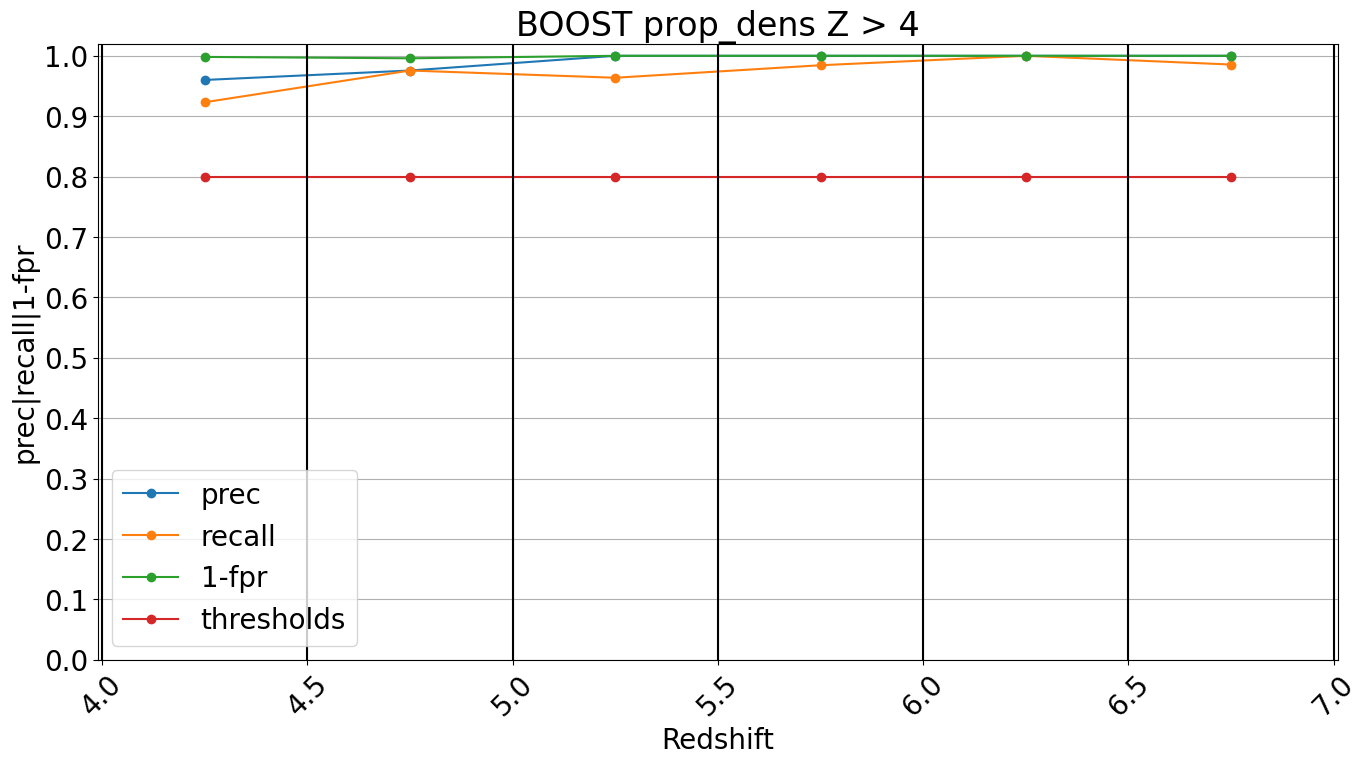

In [75]:
thrs = [0.8] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_z, quants, thrs, 'BOOST prop_dens Z > 4', plot_obj_num=False)

In [66]:
count_all(prop_dens_z, 0.8)

(0.9904761904761905, 0.9719626168224299, 0.002242152466367713)

In [67]:
ge = pd.read_csv(f'{data_dir}/dr16q_outliers_georgeedit.csv')
ge = ge[~ge['Gtest_zooTrue'].isna()]
ge = ge[ge['Z_DR16Q'] >= 4]
ge = ge[['OBJID', 'Gtest_zooTrue']]
ge.rename(columns={'Gtest_zooTrue': 'target'}, inplace=True)
ge['target'] = ge['target'].astype(int)

In [68]:
ge_02 = pd.read_csv(f'{data_dir}/dr16q_outliers_georgeedit_02.csv')
ge_02['Z_SYS_DIFF'] = ge_02['Z_SYS'] - ge_02['Z']
ge_02['target'] = ge_02['target'] = ((ge_02['gclass_zsys'] == 'TRUE') & (np.abs(ge_02['Z_SYS_DIFF']) > 0.1)) | ((ge_02['gclass_zsys'] == 'FALSE') & (np.abs(ge_02['Z_SYS_DIFF']) <= 0.1))
# ge_02 = ge_02[(ge_02['target'] == True) | (ge_02['target'] == False)]
ge_02['target'] = ge_02['target'].astype(int)
ge_02['target'][ge_02['gclass_zsys'] == '?'] = None
ge_02 = ge_02[['OBJID', 'target']]
ge_02['OBJID'] = "b'" + ge_02['OBJID']

In [69]:
manual = pd.concat((ge, ge_02), axis=0)
manual = manual.merge(dr16q, on=['OBJID'], how='inner')
manual.drop(columns=('target_y'), inplace=True)
manual.rename(columns={'target_x': 'target'}, inplace=True)
manual.replace(np.nan, -1, inplace=True)
manual

,OBJID,target,RA,DEC,Z,Z_SYS,Z_SYS_ERR,Z_SYS_DIFF,Z_SYS_DIFF_ABS,dr16q,...,sigma_12_35,sigma_13_35,sigma_14_35,sigma,mode,z_diff,z_diff_abs,preds,naive_preds,naive_z4_preds
0,b'10901-58397-0775',1.0,255.257391,33.044762,4.049514,4.031855,0.008163,-0.017659,0.017659,True,...,0.086604,0.165364,1.142307,0.086419,1.337084,-2.674231,2.674231,0.928567,0.989051,0.873797
1,b'8429-57893-0786',0.0,235.717805,49.629569,4.050000,4.045866,0.015016,-0.004134,0.004134,True,...,0.133605,0.535236,0.235277,0.241321,4.04085,-1.256229,1.256229,0.589462,0.801628,0.390682
2,b'7601-56959-0772',1.0,354.533995,21.080273,4.051000,4.051,-1.0,0.0,0.0,True,...,1.633868,0.184608,0.127518,0.180361,1.231264,-2.723943,2.723943,0.818650,0.990170,0.882713
3,b'11353-58467-0185',1.0,159.546936,28.045923,4.051065,4.061136,0.041027,0.010071,0.010071,True,...,0.553872,0.208113,0.263146,0.269738,1.284359,-2.915486,2.915486,0.993706,0.993517,0.912119
4,b'11340-58433-0898',1.0,337.892668,5.772371,4.088112,4.124339,0.032329,0.036227,0.036227,True,...,0.086474,0.168837,1.519878,0.073428,1.339406,-2.76317,2.76317,0.993637,0.990972,0.889358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,b'4198-55480-0090',0.0,330.658145,-1.038318,4.102000,4.107836,0.00721,0.005836,0.005836,True,...,0.166285,0.559538,0.239414,0.216456,3.989882,-3.67656,3.67656,0.351081,0.998770,0.973836
70,b'6830-56429-0648',0.0,197.419602,57.552767,4.281000,4.284448,0.005949,0.003448,0.003448,True,...,1.842936,0.604634,0.142598,0.205014,3.967093,-3.948,3.948,0.066546,0.999321,0.983248
71,b'4716-55738-0002',0.0,230.940419,33.799956,5.330000,5.33,-1.0,0.0,0.0,True,...,0.08385,0.040271,0.965027,0.071617,5.13625,-1.02,1.02,0.225492,0.706595,0.301358
72,b'8505-57834-0295',0.0,211.081841,40.093836,4.008000,3.989247,0.009488,-0.018753,0.018753,True,...,0.078532,0.541388,0.240573,0.119877,4.243758,-3.612173,3.612173,0.248810,0.998584,0.970938


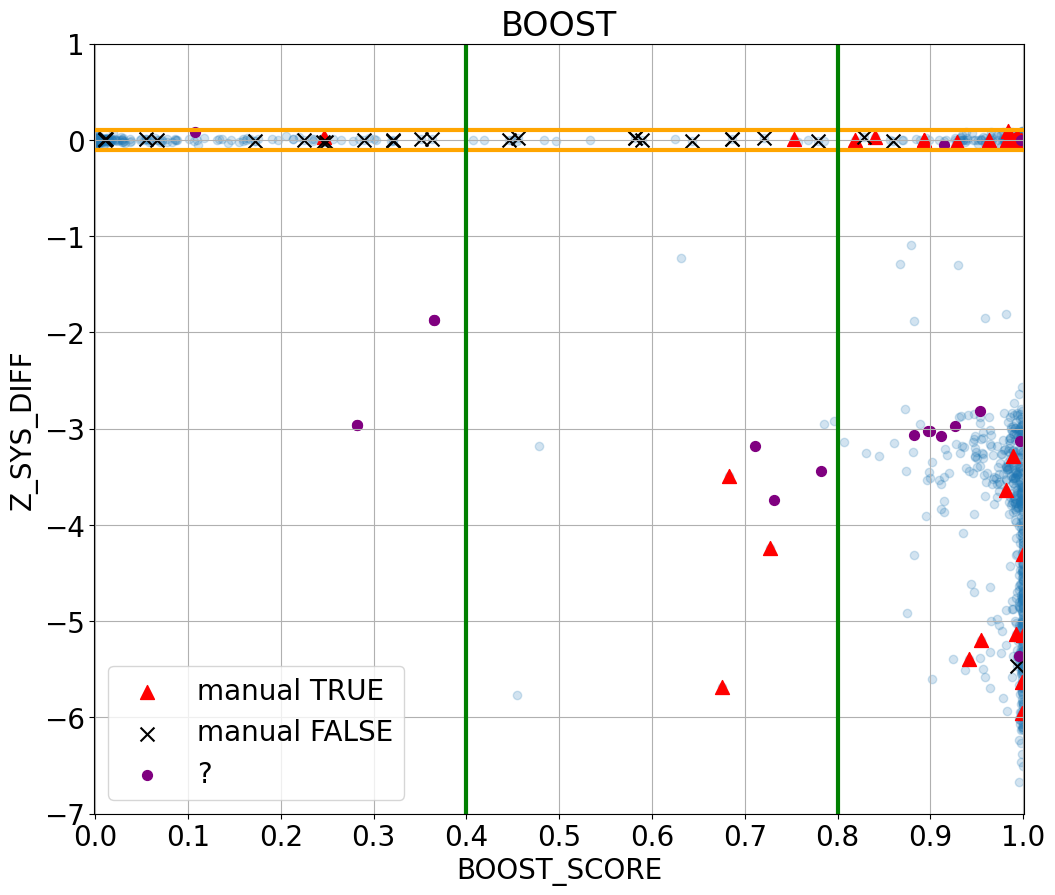

In [76]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(-0.001, 1.001)
plt.ylim(-7.0, 1)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.grid()

t = dr16q[(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['preds'], t['Z_SYS_DIFF'], alpha=0.2)
plt.scatter(manual[manual['target'] == 1]['preds'], manual[manual['target'] == 1]['Z_SYS_DIFF'], color='r', label='manual TRUE', marker='^', s=100)
plt.scatter(manual[manual['target'] == 0]['preds'], manual[manual['target'] == 0]['Z_SYS_DIFF'], color='black', label='manual FALSE', marker='x', s=100)
plt.scatter(manual[manual['target'] == -1]['preds'], manual[manual['target'] == -1]['Z_SYS_DIFF'], color='purple', label='?', marker='o', s=50)
plt.hlines([-0.1, 0.1], xmin=-1, xmax=2, colors='orange', linewidth=3)
plt.vlines([0.4, 0.8], ymin=-8, ymax=2, color='green', linewidth=3)

plt.xlabel('BOOST_SCORE')
plt.ylabel('Z_SYS_DIFF')
plt.legend()
plt.title('BOOST')
pass;

In [71]:
manual[(manual['Z_SYS_DIFF_ABS'] <= 0.1) & (manual['preds'] >= 0.8)]['target'].shape

(19,)

In [72]:
(manual[(manual['Z_SYS_DIFF_ABS'] <= 0.1) & (manual['preds'] >= 0.8)]['target'] == 1).sum()

15

In [73]:
t[t['preds'] >= 0.8].shape

(735, 138)

In [74]:
t[(t['preds'] >= 0.8) & (t['Z_SYS_DIFF_ABS'] <= 0.1)].shape[0] * 

SyntaxError: invalid syntax (136318434.py, line 1)

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(0, -7)
plt.grid()

t = dr16q[(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['z_diff'], t['Z_SYS_DIFF'], alpha=0.3)

plt.scatter(manual[manual['target'] == 1]['z_diff'], manual[manual['target'] == 1]['Z_SYS_DIFF'], color='r', label='manual TRUE', marker='x', s=100)
plt.scatter(manual[manual['target'] == 0]['z_diff'], manual[manual['target'] == 0]['Z_SYS_DIFF'], color='black', label='manual FALSE', marker='x', s=100)
plt.scatter(manual[manual['target'] == -1]['z_diff'], manual[manual['target'] == -1]['Z_SYS_DIFF'], color='purple', label='?', marker='o', s=50)

plt.xlabel('z_diff')
plt.ylabel('Z_SYS_DIFF')
plt.legend()
pass;

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(-0.01, 1.01)
plt.ylim(-7, 1.0)
plt.grid()

t = dr16q[np.abs(dr16q['Z_SYS_DIFF']) <= 0.1][(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['preds'], t['z_diff'], alpha=0.3)
plt.scatter(manual[manual['target'] == 1]['preds'], manual[manual['target'] == 1]['z_diff'], color='r', label='manual TRUE', marker='^', s=100)
plt.scatter(manual[manual['target'] == 0]['preds'], manual[manual['target'] == 0]['z_diff'], color='black', label='manual FALSE', marker='x', s=100)
plt.scatter(manual[manual['target'] == -1]['preds'], manual[manual['target'] == -1]['z_diff'], color='purple', label='?', marker='o', s=50)

plt.ylabel('z_diff')
plt.xlabel('boost_score')
plt.legend()
pass;

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.grid()

t = dr16q[np.abs(dr16q['Z_SYS_DIFF']) <= 0.1][(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['preds'], t['naive_preds'], alpha=0.3)
plt.scatter(manual[manual['target'] == 1]['preds'], manual[manual['target'] == 1]['naive_preds'], color='r', label='manual TRUE', marker='x', s=100)
plt.scatter(manual[manual['target'] == 0]['preds'], manual[manual['target'] == 0]['naive_preds'], color='black', label='manual FALSE', marker='x', s=100)
plt.scatter(manual[manual['target'] == -1]['preds'], manual[manual['target'] == -1]['naive_preds'], color='purple', label='?', marker='o', s=50)

plt.xlabel('boost_score')
plt.ylabel('naive')
plt.legend()
pass;

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.grid()

t = dr16q[np.abs(dr16q['Z_SYS_DIFF']) <= 0.1][(dr16q['Z_SYS'] > -1) & (dr16q['Z'] >= 4)]

plt.scatter(t['preds'], t['naive_z4_preds'], alpha=0.3)
plt.scatter(manual[manual['target'] == 1]['preds'], manual[manual['target'] == 1]['naive_z4_preds'], color='r', label='manual TRUE', marker='x', s=100)
plt.scatter(manual[manual['target'] == 0]['preds'], manual[manual['target'] == 0]['naive_z4_preds'], color='black', label='manual FALSE', marker='x', s=100)
plt.scatter(manual[manual['target'] == -1]['preds'], manual[manual['target'] == -1]['naive_z4_preds'], color='purple', label='?', marker='o', s=50)

plt.ylabel('naive')
plt.xlabel('boost_score')
plt.legend()
pass;

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()

plt.hist(prop_dens[prop_dens['dr16q_prop']]['z_diff_abs'], bins=20, density=True, alpha=0.7)
plt.hist(prop_dens[prop_dens['train20']]['z_diff_abs'], bins=20, density=True, alpha=0.7)
plt.xlabel('z_diff_abs')
# plt.title('boost_outliers')
pass;

In [ ]:
start = time.time()
naive_log = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01[:, 0].reshape(-1, 1), y_01)
print('naive train time: ', time.time() - start)
a = naive_log.coef_[0][0]
b = naive_log.intercept_[0] 
print(a, b, -b/a)
prop_dens_log = prop_dens[['z_diff_abs', 'Z', 'dr16q_prop', 'train20', 'target']].copy()
start = time.time()
prop_dens_log_preds = naive_log.predict_proba(prop_dens_log['z_diff_abs'].values.reshape(-1, 1))[:, 1]
print('naive inf time: ', time.time() - start)
prop_dens_log['preds'] = prop_dens_log_preds
prop_dens_log_z = prop_dens_log[prop_dens_log['Z'] >= 4]

In [ ]:
thrs = [0.8] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_log_z, quants, thrs, 'prop_dens Z > 0 (naive log)')

In [ ]:
X_01_z4 = np.concatenate([train_20_01[train_20_01['Z'] >= 4][features_list].values, superset_01[superset_01['Z'] >= 4][features_list].values], axis=0)
y_01_z4 = np.concatenate([train_20_01[train_20_01['Z'] >= 4]['target'].values, superset_01[superset_01['Z'] >= 4]['target'].values], axis=0).astype(int)
X_02_z4 = np.concatenate([train_20_02[train_20_02['Z'] >= 4][features_list].values, superset_02[superset_02['Z'] >= 4][features_list].values], axis=0)
y_02_z4 = np.concatenate([train_20_02[train_20_02['Z'] >= 4]['target'].values, superset_02[superset_02['Z'] >= 4]['target'].values], axis=0).astype(int)

In [ ]:
naive_log_z4 = LogisticRegression(solver='lbfgs', C=1, random_state=0).fit(X_01_z4[:, 0].reshape(-1, 1), y_01_z4)
a = naive_log_z4.coef_[0][0]
b = naive_log_z4.intercept_[0] 
print(a, b, -b/a)
prop_dens_log_z4 = prop_dens[['z_diff_abs', 'Z', 'dr16q_prop', 'train20', 'target']].copy()
prop_dens_log_z4_preds = naive_log_z4.predict_proba(prop_dens_log['z_diff_abs'].values.reshape(-1, 1))[:, 1]
prop_dens_log_z4['preds'] = prop_dens_log_z4_preds
prop_dens_log_z4_z = prop_dens_log_z4[prop_dens_log_z4['Z'] >= 4]

In [ ]:
thrs = [0.8] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_log_z4_z, quants, thrs, 'prop_dens Z > 4 (naive log Z > 4)')

In [ ]:
start = time.time()
rf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=0, n_jobs=12).fit(X_01, y_01)
print('rf train time: ', time.time() - start)
prop_dens_rf = prop_dens.copy()
start = time.time()
prop_dens_rf_preds = rf.predict_proba(prop_dens_rf[features_list].values)[:, 1]
print('rf inf time: ', time.time() - start)
prop_dens_rf['preds'] = prop_dens_rf_preds
prop_dens_rf_z = prop_dens_rf[prop_dens_rf['Z'] >= 4]

In [ ]:
thrs = [0.3] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_rf_z, quants, thrs, 'prop_dens Z > 4 (rf)')

In [ ]:
start = time.time()
logreg = LogisticRegression(solver='lbfgs', C=0.01, random_state=0).fit(X_01, y_01)
print('logreg train time: ', time.time() - start)
prop_dens_logreg = prop_dens.copy()
start = time.time()
prop_dens_logreg_preds = logreg.predict_proba(prop_dens_logreg[features_list].values)[:, 1]
print('logreg inf time: ', time.time() - start)
prop_dens_logreg['preds'] = prop_dens_logreg_preds
prop_dens_logreg_z = prop_dens_logreg[prop_dens_logreg['Z'] >= 4]

In [ ]:
thrs = [0.5] * (len(quants)-1)

_, _, _ = plot_all(prop_dens_logreg_z, quants, thrs, 'prop_dens Z > 4 (logreg)')

In [ ]:
fpr_boost, tpr_boost, thrs_boost = roc_curve(prop_dens_z['target'], prop_dens_z['preds'], pos_label=1)
fpr_naive_log, tpr_naive_log, thrs_naive_log = roc_curve(prop_dens_log_z['target'], prop_dens_log_z['preds'], pos_label=1)
fpr_rf, tpr_rf, thrs_rf = roc_curve(prop_dens_rf_z['target'], prop_dens_rf_z['preds'], pos_label=1)
fpr_logreg, tpr_logreg, thrs_logreg = roc_curve(prop_dens_logreg_z['target'], prop_dens_logreg_z['preds'], pos_label=1)

print('boost: ', roc_auc_score(prop_dens_z['target'], prop_dens_z['preds']))
print('naive: ', roc_auc_score(prop_dens_log_z['target'], prop_dens_log_z['preds']))
print('rf: ', roc_auc_score(prop_dens_rf_z['target'], prop_dens_rf_z['preds']))
print('logreg: ', roc_auc_score(prop_dens_logreg_z['target'], prop_dens_logreg_z['preds']))

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(14, 10))
plt.grid()

plt.plot(fpr_boost, tpr_boost, label='boost')
plt.plot(fpr_naive_log, tpr_naive_log, label='naive_logreg')
plt.plot(fpr_rf, tpr_rf, label='rf')
plt.plot(fpr_logreg, tpr_logreg, label='logreg')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_CURVE')
plt.legend()
pass;

In [ ]:
full[full['dr16q_prop']]

In [ ]:
# dfs = []

# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(12, 10))
# plt.xlim(-0.001, 1.001)
# plt.ylim(-7.0, 1)
# plt.xticks(np.arange(0.0, 1.1, 0.1))
# plt.grid()

# t00 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] < 0.1)]
# t00_01 = t00.iloc[np.random.choice(np.arange(t00.shape[0]), 4, replace=False)]
# dfs.append(t00_01)
# t01 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.1) & (t['preds'] < 0.2)]
# t01_01 = t01.iloc[np.random.choice(np.arange(t01.shape[0]), 2, replace=False)]
# dfs.append(t01_01)
# t02 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.2) & (t['preds'] < 0.3)]
# t02_01 = t02.iloc[np.random.choice(np.arange(t02.shape[0]), 2, replace=False)]
# dfs.append(t02_01)
# t03 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.3) & (t['preds'] < 0.4)]
# t03_01 = t03.iloc[np.random.choice(np.arange(t03.shape[0]), 2, replace=False)]
# dfs.append(t03_01)
# t04 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.4) & (t['preds'] < 0.8)]
# t04_01 = t04.iloc[np.random.choice(np.arange(t04.shape[0]), 5, replace=False)]
# dfs.append(t04_01)
# t05 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.8) & (t['preds'] < 0.9)]
# t05_01 = t05.iloc[np.random.choice(np.arange(t05.shape[0]), 3, replace=False)]
# dfs.append(t05_01)
# t06 = t[(np.abs(t['Z_SYS_DIFF']) <= 0.1) & (t['preds'] >= 0.9)]
# t06_01 = t06.iloc[np.random.choice(np.arange(t06.shape[0]), 7, replace=False)]
# dfs.append(t06_01)
# t07 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] < 0.4)]
# t07_01 = t07.iloc[np.random.choice(np.arange(t07.shape[0]), t07.shape[0], replace=False)]
# dfs.append(t07_01)
# t08 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] >= 0.4) & (t['preds'] < 0.8)]
# t08_01 = t08.iloc[np.random.choice(np.arange(t08.shape[0]), 5, replace=False)]
# dfs.append(t08_01)
# t09 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] >= 0.8) & (t['preds'] < 0.9)]
# t09_01 = t09.iloc[np.random.choice(np.arange(t09.shape[0]), 3, replace=False)]
# dfs.append(t09_01)
# t10 = t[(t['Z_SYS_DIFF'] < -0.1) & (t['preds'] >= 0.9)]
# t10_01 = t10.iloc[np.random.choice(np.arange(t10.shape[0]), 7, replace=False)]
# dfs.append(t10_01)
# t11 = t[(np.abs(t['z_diff']) < 1.0) & (t['preds'] >= 0.5)]
# t11_01 = t11.iloc[np.random.choice(np.arange(t11.shape[0]), t11.shape[0], replace=False)]
# dfs.append(t11_01)
# t12 = t[(np.abs(t['z_diff']) > 1.0) & (t['preds'] <= 0.4)]
# t12_01 = t12.iloc[np.random.choice(np.arange(t12.shape[0]), t12.shape[0], replace=False)]
# dfs.append(t12_01)

# manual_data = pd.read_csv(f'{data_dir}/manual_data.csv')
# manual_data = pd.concat(dfs, axis=0)

# plt.scatter(manual_data['preds'], manual_data['Z_SYS_DIFF'], alpha=0.3)
# plt.hlines([-0.1, 0.1], xmin=-1, xmax=2, colors='orange', linewidth=3)
# plt.vlines([0.4, 0.8], ymin=-8, ymax=2, color='green', linewidth=3)

# plt.xlabel('boost_score')
# plt.ylabel('Z_SYS_DIFF')
# plt.legend()

# # manual_data.to_csv(f'{data_dir}/manual_data.csv', index=False)

In [ ]:
# font = {'size': 16}
# plt.rc('font', **font)
# fig = plt.figure(figsize=(12, 10))
# plt.grid()

# plt.scatter(manual_data['preds'], manual_data['z_diff'], alpha=0.3)